In [1]:
import sys
sys.version

'3.7.5 (default, Feb 23 2021, 13:22:40) \n[GCC 8.4.0]'

# Chapter 9 - Hierarchical Models

In [14]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import cm  # color map
import seaborn as sns
sns.set()
plt.style.use('seaborn-white')
plt.style.use("dark_background")
color = '#87ceeb'

from IPython.display import Image
from matplotlib import gridspec


import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from jax import random, numpy as jnp
from jax.random import PRNGKey
_ntrace = 4
numpyro.set_host_device_count(_ntrace)

import pymc3 as pm

In [3]:
%load_ext watermark
%watermark -p numpyro,arviz,scipy,numpy,pandas,pymc3

numpyro: 0.5.0
arviz  : 0.11.2
scipy  : 1.6.0
numpy  : 1.19.5
pandas : 1.2.1
pymc3  : 3.11.0



In [4]:
# convenience function
def gomcmc(model, data, num_samples=4000):
    """
    data: dict() type for model function
    """
    mcmc = MCMC(NUTS(model), num_warmup=1500, num_samples=num_samples, num_chains=_ntrace)
    mcmc.run(PRNGKey(0), **data)
    return mcmc

## 9.5. Extending the Hierarchy: Subjects within categories

### 9.5.1 - Example: Baseball batting abilities by position

In [5]:
df2 = pd.read_csv('data/BattingAverage.csv', 
                  usecols=[0,1,2,3], 
                  dtype={'PriPos':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Player  948 non-null    object  
 1   PriPos  948 non-null    category
 2   Hits    948 non-null    int64   
 3   AtBats  948 non-null    int64   
dtypes: category(1), int64(2), object(1)
memory usage: 23.6+ KB


In [6]:
df2

,Player,PriPos,Hits,AtBats
0,Fernando Abad,Pitcher,1,7
1,Bobby Abreu,Left Field,53,219
2,Tony Abreu,2nd Base,18,70
3,Dustin Ackley,2nd Base,137,607
4,Matt Adams,1st Base,21,86
...,...,...,...,...
943,Brad Ziegler,Pitcher,1,4
944,Ryan Zimmerman,3rd Base,163,578
945,Jordan Zimmermann,Pitcher,11,57
946,Barry Zito,Pitcher,4,53


In [7]:
df2.PriPos.unique()

['Pitcher', 'Left Field', '2nd Base', '1st Base', '3rd Base', 'Catcher', 'Shortstop', 'Center Field', 'Right Field']
Categories (9, object): ['Pitcher', 'Left Field', '2nd Base', '1st Base', ..., 'Catcher', 'Shortstop', 'Center Field', 'Right Field']

The DataFrame contains records for 948 players in the 2012 regular season of Major League Baseball.
- One record per player
- 9 primary field positions

In [8]:
# Hit rate by primary field positions
perPosition = df2.groupby('PriPos')[['Hits', 'AtBats']]
pphit = perPosition.sum()
pphit['hit_rate'] = pphit['Hits'] / pphit['AtBats']
pphit

,Hits,AtBats,hit_rate
PriPos,,,
1st Base,5900,22793,0.258851
2nd Base,5068,19822,0.255676
3rd Base,5460,20601,0.265036
Catcher,4766,19264,0.247404
Center Field,4963,18834,0.263513
Left Field,5723,22090,0.259077
Pitcher,650,5033,0.129148
Right Field,4992,18941,0.263555
Shortstop,4478,17548,0.255186


In [9]:
# Batting average by primary field positions calculated from the data
df2.groupby('PriPos')[['Hits','AtBats']].sum().pipe(lambda x: x.Hits/x.AtBats)

PriPos
1st Base        0.258851
2nd Base        0.255676
3rd Base        0.265036
Catcher         0.247404
Center Field    0.263513
Left Field      0.259077
Pitcher         0.129148
Right Field     0.263555
Shortstop       0.255186
dtype: float64

#### Model (Kruschke, 2015)

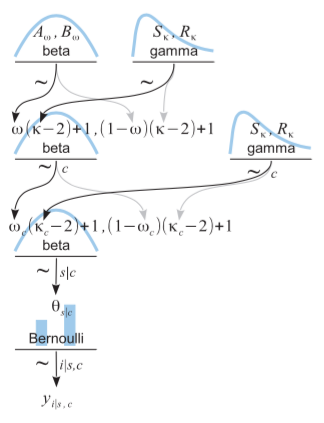

In [10]:
Image('images/fig9_13.png', width=400)

### Data

In [15]:
pripos_idx = df2.PriPos.cat.codes.values
pripos_codes = df2.PriPos.cat.categories
n_pripos = pripos_codes.size

# df2 contains one entry per player
n_players = df2.index.size

In [16]:
n_pripos, n_players, len(pripos_idx), len(pripos_codes)

(9, 948, 948, 9)

In [17]:
np.unique(pripos_idx)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int8)

## NumPyro Model
- The book uses Gamma(0.01, 0.01) to get a flat distribution for $kappa-1$, but its samples generated does not seem flat over a reasonable range. Other parameters or even other distributions like Exp should be considered.

### Modeling

In [18]:
def model(n_pripos, n_players, pripos_idx, atBats, Hits=None):
    """
    pripos_idx, atBats, Hits: jnp DeviceArray
    """
    omega = numpyro.sample('omega', dist.Beta(1,1))  # 
    kappa_minus2 = numpyro.sample('kappa_minus2', dist.Gamma(0.01, 0.01))
    kappa = kappa_minus2 + 2
    numpyro.deterministic('kappa', kappa)  # just to make record
    
    # categoris: Primary field positions
    with numpyro.plate('omega_c_plate', size=n_pripos):  # equivalent to running a for loop
        omega_c = numpyro.sample('omega_c', dist.Beta(omega*(kappa-2)+1, (1-omega)*(kappa-2)+1))
        kappa_c_minus2 = numpyro.sample('kappa_c_minus2', dist.Gamma(0.01, 0.01))
#     print('# num of primary positions: ', omega_c.shape)  # should be 9
    
    kappa_c = kappa_c_minus2 + 2
    numpyro.deterministic('kappa_c', kappa_c)
    
    alpha = omega_c[pripos_idx] * (kappa_c[pripos_idx] - 2) + 1
    beta  = (1-omega_c[pripos_idx]) * (kappa_c[pripos_idx] - 2) + 1
    
#     with numpyro.plate('theta_sample', size=n_players):
    theta = numpyro.sample('theta', dist.Beta(alpha, beta))
        
#     with numpyro.plate('observation', size=n_players):
    numpyro.sample('obs', dist.Binomial(total_count=atBats, probs=theta), obs=Hits)

### Prior Predictive Check

In [19]:
prior_check = Predictive(model, num_samples=2021)(random.PRNGKey(0), n_pripos, n_players, jnp.array(pripos_idx), jnp.array(df2.AtBats.values))
prior_check = {k: np.array(v) for k, v in prior_check.items()}

In [20]:
prior_check.keys()

dict_keys(['kappa', 'kappa_c', 'kappa_c_minus2', 'kappa_minus2', 'obs', 'omega', 'omega_c', 'theta'])

In [21]:
prior_check['obs'].shape

(2021, 948)

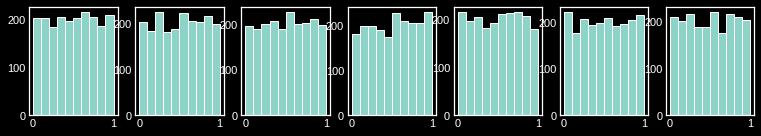

In [22]:
fig, axes = plt.subplots(1, 7, figsize=(13,2))
for i, ax in enumerate(axes.ravel()):
    ax.hist(prior_check['theta'][:,i])  # distriubtion of theta_i should be almost flat since we have no observation enforced yet.

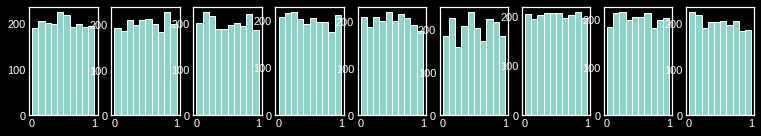

In [23]:
fig, axes = plt.subplots(1, 9, figsize=(13,2))
for i, ax in enumerate(axes.ravel()):
    ax.hist(prior_check['omega_c'][:, i])  # flat for the same reason

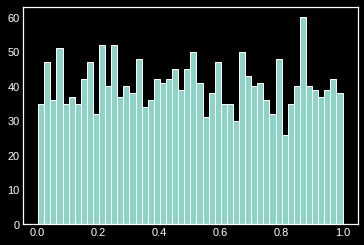

In [24]:
plt.hist(prior_check['omega'], bins=50);

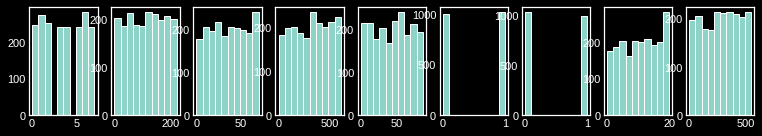

In [25]:
fig, axes = plt.subplots(1, 9, figsize=(13,2))
for i, ax in enumerate(axes.ravel()):
    ax.hist(prior_check['obs'][:, i])  # flat for the same reason

### Prepare Data for Inference with numpyro

In [26]:
npr_data = dict(n_pripos = n_pripos, 
                n_players = n_players,
                pripos_idx = jnp.array(pripos_idx),
                atBats = jnp.array(df2.AtBats.values),
                Hits = jnp.array(df2.Hits.values)
               )

### Run MCMC

In [27]:
%%time
mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=2000, num_chains=_ntrace)  # progress bar not yet implemented in numpyro for multiple traces
mcmc.run(PRNGKey(0), **npr_data)

CPU times: user 2min 2s, sys: 21.7 s, total: 2min 24s
Wall time: 28.8 s


In [28]:
inferenceData = az.from_numpyro(mcmc)
trace = inferenceData.posterior
trace

<xarray.Dataset>
Dimensions:               (chain: 4, draw: 2000, kappa_c_dim_0: 9, kappa_c_minus2_dim_0: 9, omega_c_dim_0: 9, theta_dim_0: 948)
Coordinates:
  * chain                 (chain) int64 0 1 2 3
  * draw                  (draw) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
  * kappa_c_dim_0         (kappa_c_dim_0) int64 0 1 2 3 4 5 6 7 8
  * kappa_c_minus2_dim_0  (kappa_c_minus2_dim_0) int64 0 1 2 3 4 5 6 7 8
  * omega_c_dim_0         (omega_c_dim_0) int64 0 1 2 3 4 5 6 7 8
  * theta_dim_0           (theta_dim_0) int64 0 1 2 3 4 ... 943 944 945 946 947
Data variables:
    kappa                 (chain, draw) float32 114.1 92.44 55.9 ... 43.29 77.07
    kappa_c               (chain, draw, kappa_c_dim_0) float32 209.9 ... 229.2
    kappa_c_minus2        (chain, draw, kappa_c_minus2_dim_0) float32 207.9 ....
    kappa_minus2          (chain, draw) float32 112.1 90.44 53.9 ... 41.29 75.07
    omega                 (chain, draw) float32 0.2346 0.2261 ... 0.2245 0.225
    omega_c               (chain, draw, omega_c_dim_0) float32 0.2536 ... 0.2478
    theta                 (chain, draw, theta_dim_0) float32 0.1037 ... 0.2721
Attributes:
    created_at:                 2021-03-19T15:49:15.022170
    arviz_version:              0.11.2
    inference_library:          numpyro
    inference_library_version:  0.5.0

### Trace Plots

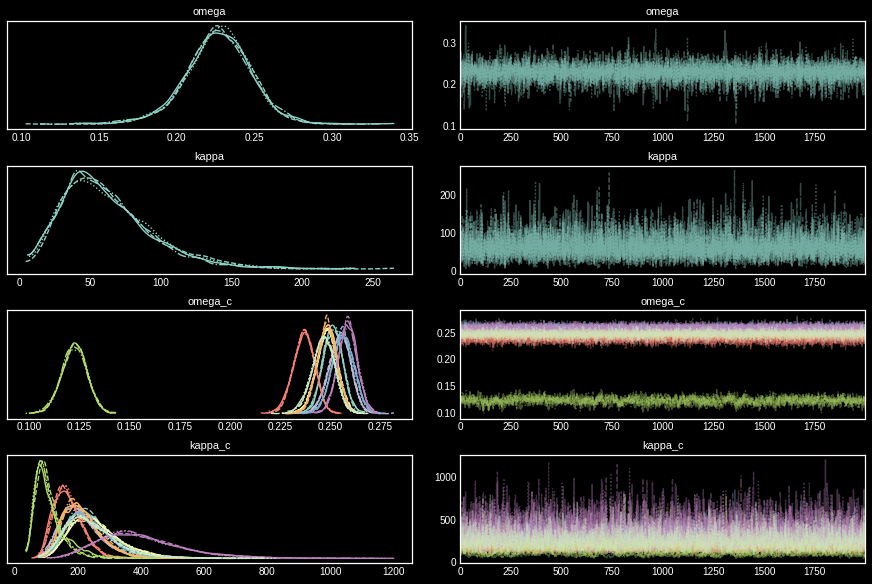

In [29]:
az.plot_trace(trace, ['omega', 'kappa', 'omega_c', 'kappa_c']);

### Posterior Plots

#### Figure 9.14 Marginal posterior for Pitcher and Catcher

In [30]:
pitcher_id = list(pripos_codes).index('Pitcher')
catcher_id = list(pripos_codes).index('Catcher')
pitcher = np.array(trace.omega_c[:,:, pitcher_id]).reshape(-1)
catcher = np.array(trace.omega_c[:,:, catcher_id]).reshape(-1)
pmc = pitcher - catcher # posterior samples of the difference
pmc.shape

(8000,)

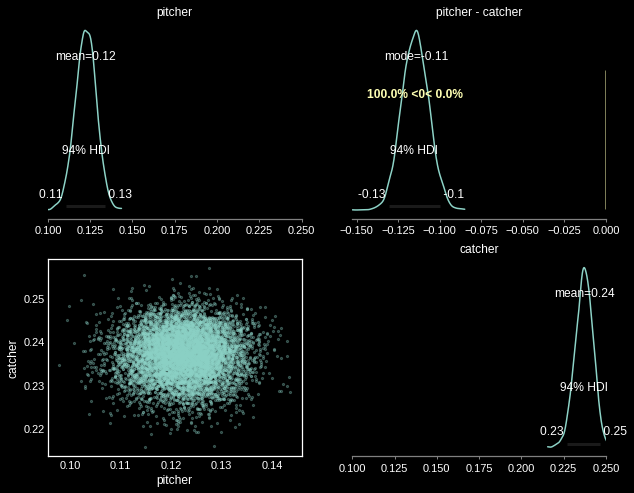

In [31]:
fig, axes = plt.subplots(2,2, figsize=(10,8))
ax0, ax1, ax2, ax3 = axes.ravel()
az.plot_posterior(pitcher, ax=ax0)
ax0.set_xlim(0.1, 0.25); ax0.set_title('pitcher')
az.plot_posterior(pmc, point_estimate='mode', ref_val=0., ax=ax1); ax1.set_xlim(pmc.min(), 0); ax1.set_title('pitcher - catcher');
ax2.scatter(pitcher, catcher, marker='o', s=5, alpha=.3)
ax2.set_xlabel('pitcher'); ax2.set_ylabel('catcher')
az.plot_posterior(catcher, ax=ax3)
ax3.set_xlim(0.1, 0.25); ax3.set_title('catcher');

In [32]:
def plot_difference(omega_c, namelist, title=None):
    pitcher_id = list(pripos_codes).index(namelist[0])
    catcher_id = list(pripos_codes).index(namelist[1])

    pitcher = np.array(omega_c[:,:, pitcher_id]).reshape(-1)
    catcher = np.array(omega_c[:,:, catcher_id]).reshape(-1)
    pmc = pitcher - catcher # posterior samples of the difference

    fig, axes = plt.subplots(2,2, figsize=(10,8))
    ax0, ax1, ax2, ax3 = axes.ravel()
    
    az.plot_posterior(pitcher, point_estimate='mean',ax=ax0); ax0.set_title(namelist[0])
    
    az.plot_posterior(pmc, point_estimate='mean', ref_val=0., ax=ax1); ax1.set_title(f'{namelist[0]} - {namelist[1]}');
    
    ax2.scatter(pitcher, catcher, marker='o', s=5, alpha=.3); ax2.set_xlabel(namelist[0]); ax2.set_ylabel(namelist[1])
    ax2.plot([0,1], [0,1], '--')
    ax2.set_xlim(pitcher.min()*.99, pitcher.max()*1.01)
    ax2.set_ylim(catcher.min()*.99, catcher.max()*1.01)
    
    az.plot_posterior(catcher, point_estimate='mean',ax=ax3); ax3.set_title(namelist[1]);
    
    for ax in [ax0, ax3]:
        ax.set_xlim(min([pitcher.min(), catcher.min()]),  max([pitcher.max(), catcher.max()]))
    
    if title is not None:
        fig.suptitle(title)

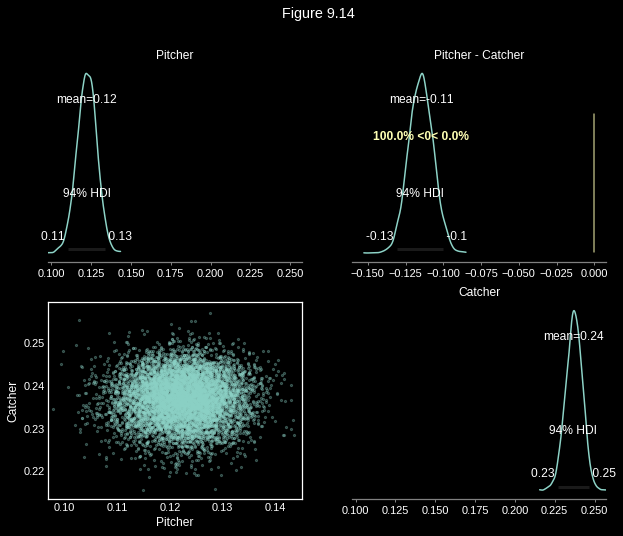

In [33]:
plot_difference(trace.omega_c, ['Pitcher', 'Catcher'],
               title='Figure 9.14')

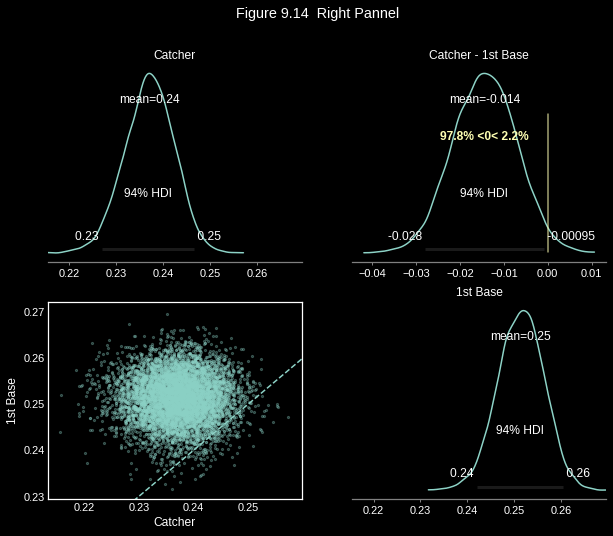

In [34]:
plot_difference(trace.omega_c, ['Catcher', '1st Base'],
               title='Figure 9.14  Right Pannel')

Plot for players

#### **Figure 9.17** Posterior distributions of the omega_c parameters after sampling.

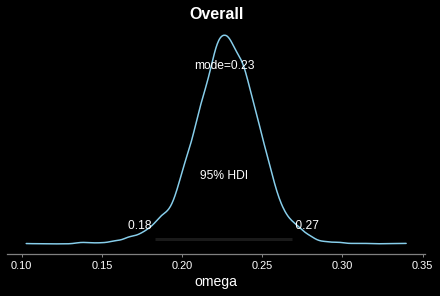

In [35]:
az.plot_posterior(trace, var_names=['omega'], point_estimate='mode', hdi_prob=.95, color=color)
plt.title('Overall', fontdict={'fontsize':16, 'fontweight':'bold'})
plt.xlabel('omega', fontdict={'fontsize':14});

**Figure 9.17** Posterior distributions of the omega_c parameters after sampling.

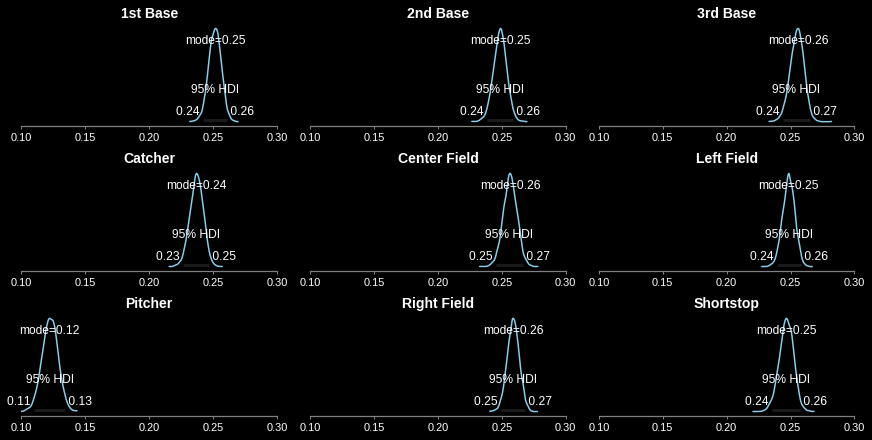

In [36]:
# fig, axes = plt.subplots(3, 3, figsize=(15,5))
axes = az.plot_posterior(trace, var_names=['omega_c'], point_estimate='mode', hdi_prob=.95, color=color, figsize=(12,6));
for ax, pname in zip(axes.ravel(), pripos_codes):
    ax.set_title(pname, fontdict={'fontsize':14, 'fontweight':'bold'})
    ax.set_xlim(0.10,0.30)

## PyMC3 Model

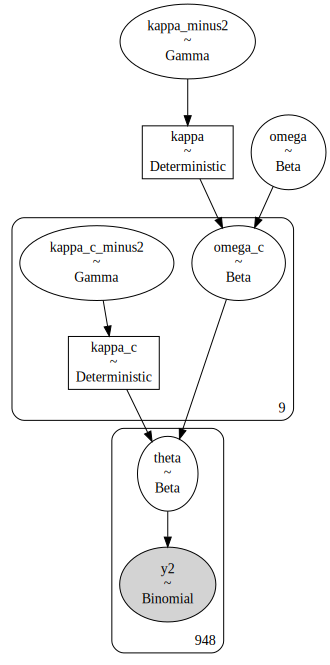

In [37]:
with pm.Model() as hierarchical_model2:
    # Hyper parameters
    omega = pm.Beta('omega', 1, 1)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    # Parameters for categories (Primary field positions)
    omega_c = pm.Beta('omega_c',
                       omega*(kappa-2)+1, (1-omega)*(kappa-2)+1,
                       shape = n_pripos)
    
    kappa_c_minus2 = pm.Gamma('kappa_c_minus2',
                              0.01, 0.01,
                              shape = n_pripos)
    kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
        
    # Parameter for individual players
    theta = pm.Beta('theta',
                     omega_c[pripos_idx]*(kappa_c[pripos_idx]-2)+1,
                    (1-omega_c[pripos_idx])*(kappa_c[pripos_idx]-2)+1,
                     shape = n_players)
    
    y2 = pm.Binomial('y2', n=df2.AtBats.values, p=theta, observed=df2.Hits)

pm.model_to_graphviz(hierarchical_model2)

In [38]:
with hierarchical_model2:
    trace2 = pm.sample(3000, cores=4)

/home/yndk/.local/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_c_minus2, omega_c, kappa_minus2, omega]
INFO:pymc3:NUTS: [theta, kappa_c_minus2, omega_c, kappa_minus2, omega]


/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 44 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_00

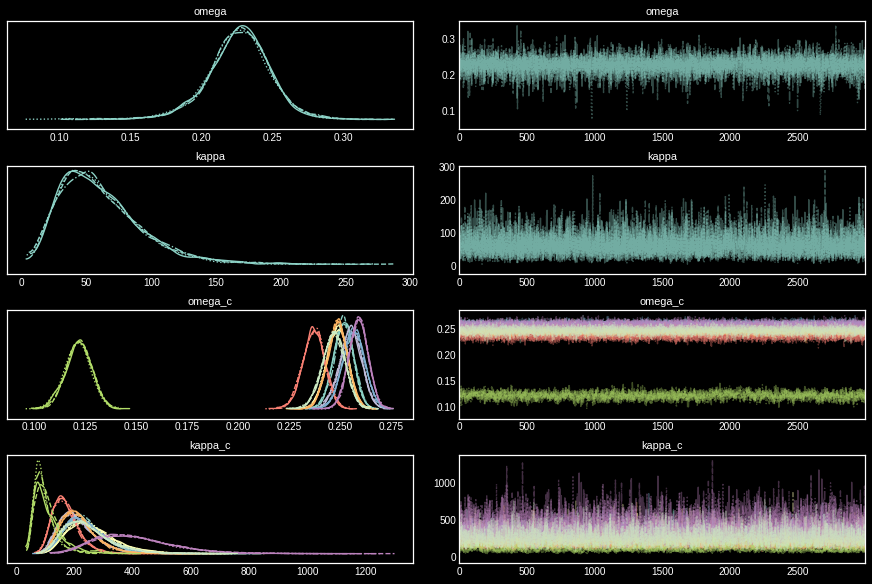

In [39]:
with hierarchical_model2:
    az.plot_trace(trace2, ['omega', 'kappa', 'omega_c', 'kappa_c']);

### Figure 9.17

#### Posterior distribution of hyper parameter omega after sampling.

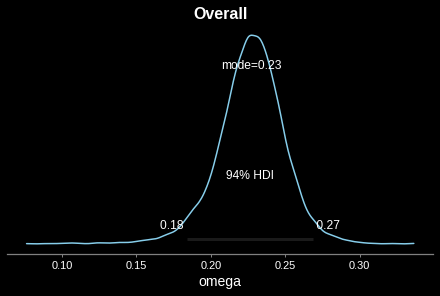

In [40]:
az.plot_posterior(trace2['omega'], point_estimate='mode', color=color)
plt.title('Overall', fontdict={'fontsize':16, 'fontweight':'bold'})
plt.xlabel('omega', fontdict={'fontsize':14});

#### Posterior distributions of the omega_c parameters after sampling.

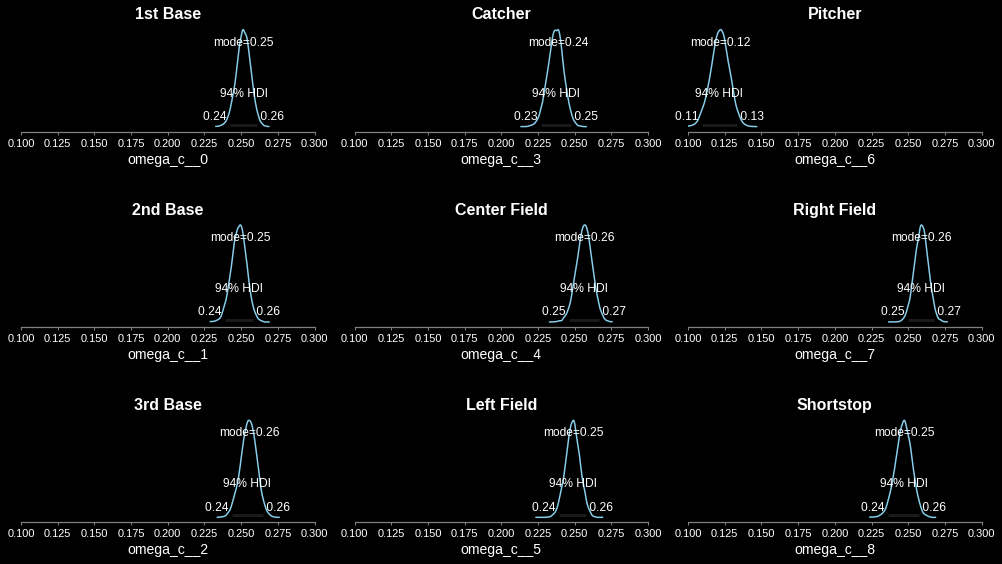

In [41]:
fig, axes = plt.subplots(3,3, figsize=(14,8))

for i, ax in enumerate(axes.T.flatten()):
    az.plot_posterior(trace2['omega_c'][:,i], ax=ax, point_estimate='mode', color=color)
    ax.set_title(pripos_codes[i], fontdict={'fontsize':16, 'fontweight':'bold'})
    ax.set_xlabel('omega_c__{}'.format(i), fontdict={'fontsize':14})
    ax.set_xlim(0.10,0.30)

plt.tight_layout(h_pad=3)

End.

---

## Gamma Distribution
https://en.wikipedia.org/wiki/Gamma_distribution
- Its domain (or support): $x \in (0, \infty)$
- Three ways of parametrization of Gamma distribution
    1. shape, scale: $(\kappa, \theta)$
    2. shape, rate: $(\alpha, \beta)$, where $\alpha=\kappa$ and $\beta = 1/\theta$
    3. shape, mean: $(\kappa, \mu)$, where $\mu = \kappa\theta = \alpha / \beta$
- The mode is at
    - $(\kappa - 1)\theta$ for $\kappa \geq 1$   (ss parameterization)
    - $\frac{\alpha - 1}{\beta}$ for $\alpha \geq 1$ (sr parameterization)
- Variance:
    - V = $\kappa \theta^2$ = $\frac{\alpha}{\beta^2}$

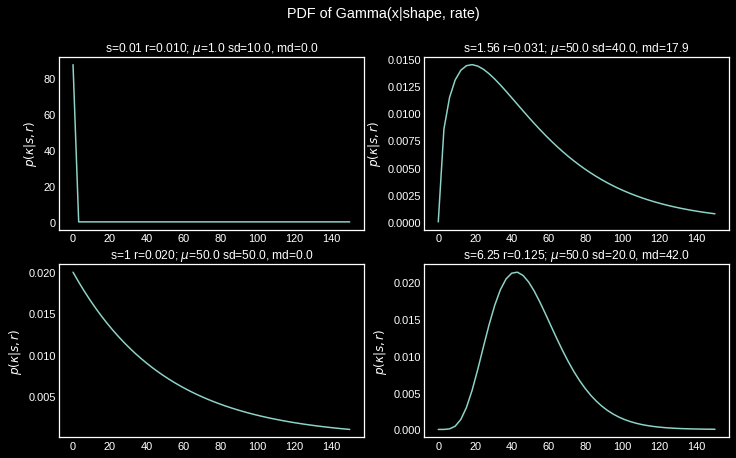

In [42]:
x=np.linspace(0.0001,150)
fig, axes = plt.subplots(2,2, figsize=(12,7))
shape_rates = [ [0.01, 0.01], [1.56, 0.0312], [1, 0.02], [6.25, 0.125] ]  # shape, rate == (alpha, beta)
for ax, (shape, rate) in zip(axes.ravel(), shape_rates):
    gammapdf = stats.gamma(a=shape, scale=1./rate).pdf(x)
    ax.plot(x, gammapdf)
    mu = shape / rate
    sd = np.sqrt(mu / rate)
    mode = (shape - 1) / rate if shape >= 1 else 0
    ax.set_title(f's={shape} r={rate:.3f}; $\mu$={mu:.1f} sd={sd:.1f}, md={mode:.1f}')
    ax.set_ylabel('$p(\kappa|s, r)$')
fig.suptitle('PDF of Gamma(x|shape, rate)');

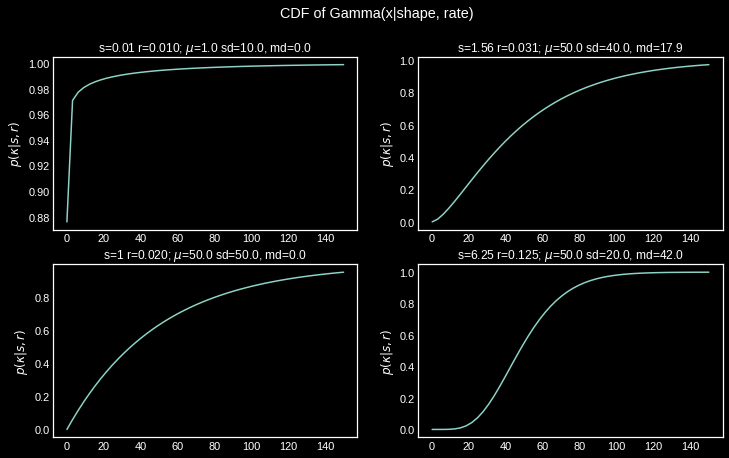

In [43]:
x=np.linspace(0.0001,150)
fig, axes = plt.subplots(2,2, figsize=(12,7))
shape_rates = [ [0.01, 0.01], [1.56, 0.0312], [1, 0.02], [6.25, 0.125] ]  # shape, rate == (alpha, beta)
for ax, (shape, rate) in zip(axes.ravel(), shape_rates):
    gammapdf = stats.gamma(a=shape, scale=1./rate).cdf(x)
    ax.plot(x, gammapdf)
    mu = shape / rate
    sd = np.sqrt(mu / rate)
    mode = (shape - 1) / rate if shape >= 1 else 0
    ax.set_title(f's={shape} r={rate:.3f}; $\mu$={mu:.1f} sd={sd:.1f}, md={mode:.1f}')
    ax.set_ylabel('$p(\kappa|s, r)$')
fig.suptitle('CDF of Gamma(x|shape, rate)');

End.

## Numpyro: with plate or not with plate?

In [44]:
with numpyro.handlers.seed(rng_seed=0):
    s = numpyro.sample('binom', dist.Binomial(total_count=100, probs=.7).expand([19]))
    print(s)

[69 64 72 68 83 66 71 67 75 71 69 73 60 64 80 70 72 71 67]


In [45]:
with numpyro.handlers.seed(rng_seed=np.random.randint(0, high=1000)):
    tcs = jnp.array([100, 22, 30, 25])
    probs = jnp.array([.7, .5, .2, .4])
    with numpyro.plate('obss', len(tcs)):  # size must be the same as len(tcs)
        s = numpyro.sample('binom', dist.Binomial(total_count=tcs, probs=probs))
    print(s)

[69 11  3 15]


In [46]:
# without plate
with numpyro.handlers.seed(rng_seed=np.random.randint(0, high=1000)):
    tcs = jnp.array([100, 22, 30, 25])
    probs = jnp.array([.7, .5, .2, .4])
    s = numpyro.sample('binom', dist.Binomial(total_count=tcs, probs=probs))
    print(s)

[76 14  6 12]


In [47]:
# without plate
with numpyro.handlers.seed(rng_seed=np.random.randint(0, high=1000)):
    tcs = jnp.array([100, 22, 30, 25])
    probs = jnp.array([.7, .5, .2, .4])
    s = numpyro.sample('binom', dist.Binomial(total_count=tcs, probs=probs))
    print(s)

[79 12  5 12]


In [48]:
trace2

<MultiTrace: 4 chains, 3000 iterations, 12 variables>

In [49]:
.1*99/(.1*99 + 5*99.9)

0.01943462897526502